# Machine Learning

In this homework we will gain experience on Applied Machine Learning, exploring an interesting dataset about soccer players and referees. 

In [1]:
import pandas as pd
import numpy as np
import os
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt  
% matplotlib inline
import random
from datetime import datetime
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'
import sklearn as sk
from sklearn import preprocessing, ensemble
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances

/Users/peco/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load data from pre-processing

In [2]:
df_p = pd.read_csv("crowdstorm_players_aggregated.csv", encoding = "utf-8")

# Machine Learning

## Preparation of the data
First let's create a vector *X* of features and samples, and a vector *Y* of the labels corresponding. Y will have the value of *mean_rater*

In [3]:
df_y = df_p['mean_rater']

df_x = df_p.copy()
df_x.drop(['mean_rater'],inplace=True,axis=1,errors='ignore')

df_x.describe()

,seExp,height,redCards,games,meanIAT,victories,weight,goals,defeats,yellowCards,...,Center Forward,Center Midfielder,Defensive Midfielder,Goalkeeper,Left Fullback,Left Midfielder,Left Winger,Right Fullback,Right Midfielder,Right Winger
count,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,1418.00000,1418.000000,1418.000000,...,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000
mean,0.001399,182.159379,7.225670,1818.977433,0.347126,820.600141,76.263047,211.35402,561.917489,242.483780,...,0.133286,0.041608,0.120592,0.111425,0.082511,0.053597,0.037377,0.075458,0.042313,0.039492
std,0.001957,6.799995,13.087291,1963.852817,0.014516,1019.439932,7.105262,428.63188,573.695929,290.131377,...,0.340004,0.199762,0.325768,0.314768,0.275238,0.225299,0.189750,0.264223,0.201374,0.194832
min,0.000037,161.000000,0.000000,1.000000,0.287530,0.000000,55.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000547,178.000000,0.000000,508.000000,0.336628,197.000000,71.000000,14.00000,173.000000,54.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.001002,182.500000,1.000000,1204.000000,0.340851,497.000000,76.000000,69.00000,384.500000,148.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.001437,187.000000,9.750000,2426.500000,0.361154,1068.750000,81.000000,221.50000,749.750000,320.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.045650,203.000000,121.000000,16932.000000,0.396512,10092.000000,100.000000,5141.00000,4269.000000,2361.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Division of the dataset in train/test datasets
we will use a training set containing 80% of the data, and a testing set containing 20% of the data

when specifying *random_state = 0*, we make sure that the splitting is done everytime at the same place. We can remove this option to have a random splitting.

In [4]:
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(df_x, df_y, test_size=.2, random_state = 0)
df_y_test = np.asarray(df_y_test, dtype="|S6")
df_x_test = np.asarray(df_x_test, dtype="|S6")
df_y_train = np.asarray(df_y_train, dtype="|S6")
df_x_train = np.asarray(df_x_train, dtype="|S6")

df_x_train.shape, df_y_train.shape, df_x_test.shape, df_y_test.shape

((1134, 30), (1134,), (284, 30), (284,))

## Random Forest

In [5]:
# TRAIN RANDOM FOREST

# Train model
rand_forest_model = sk.ensemble.RandomForestClassifier(n_estimators=10)
rand_forest_model.fit(df_x_train,df_y_train)

# Predict from model neigh
y_pred = rand_forest_model.predict(df_x_test)

#compute score
score = rand_forest_model.score(df_x_test,df_y_test)

# Compute accuracy 
accuracy_rand_forest = sk.metrics.accuracy_score(df_y_test,y_pred)

# Print accuracy
print("Accuracy score")
print(accuracy_rand_forest)


Accuracy score
0.785211267606


## Cross validation

we will define K = 20 folds.


In [6]:
num_folds = 20

### 1 hyperparameter : number of trees

Choices for the number of estimators hyperparameter:

In [7]:
number_trees = [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]

In [8]:
rf_scores = []
rf_param = []

#Loop for 1st hyperparameter n_estimators
for number_trees_idx, number_trees_value in enumerate(number_trees):
    
    print('number_trees_idx: ',number_trees_idx+1,'/',len(number_trees),', value: ', number_trees_value)

    # Random forest
    rand_forest_model = sk.ensemble.RandomForestClassifier(n_estimators=number_trees_value,)

    #Scores
    scores = cross_val_score(rand_forest_model, df_x_train, df_y_train, cv=num_folds, scoring='accuracy')
    rf_scores.append(scores.mean())
    rf_param.append(number_trees_value)
    print('Accuracy = ', scores.mean())


number_trees_idx:  1 / 14 , value:  10
Accuracy =  0.770800924726
number_trees_idx:  2 / 14 , value:  50
Accuracy =  0.777742848501
number_trees_idx:  3 / 14 , value:  100
Accuracy =  0.783162647999
number_trees_idx:  4 / 14 , value:  200
Accuracy =  0.780406836056
number_trees_idx:  5 / 14 , value:  300
Accuracy =  0.779591219428
number_trees_idx:  6 / 14 , value:  400
Accuracy =  0.783100531501
number_trees_idx:  7 / 14 , value:  500
Accuracy =  0.780468952554
number_trees_idx:  8 / 14 , value:  600
Accuracy =  0.781314817215
number_trees_idx:  9 / 14 , value:  700
Accuracy =  0.781361269553
number_trees_idx:  10 / 14 , value:  800
Accuracy =  0.782269790856
number_trees_idx:  11 / 14 , value:  900
Accuracy =  0.780483536427
number_trees_idx:  12 / 14 , value:  1000
Accuracy =  0.780453288393
number_trees_idx:  13 / 14 , value:  1100
Accuracy =  0.78045274825
number_trees_idx:  14 / 14 , value:  1200
Accuracy =  0.782207674358


#### best number of trees value : *600*

best accuracy:
0.783162647999
best parameter:
100


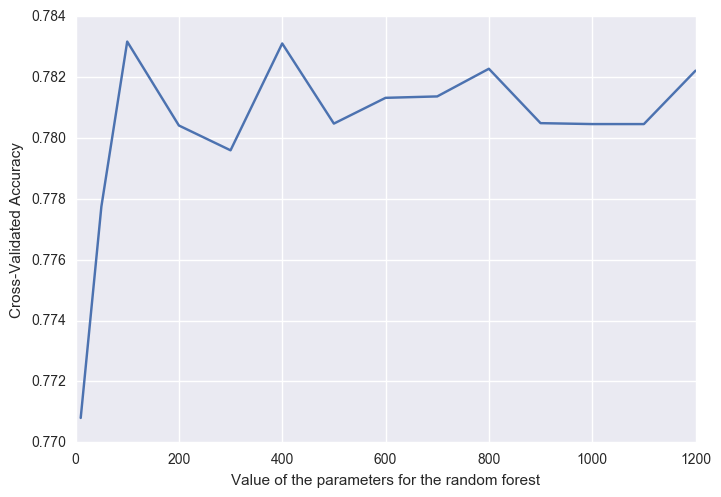

In [23]:
plt.plot(rf_param,rf_scores)
plt.xlabel('Value of the parameters for the random forest')
plt.ylabel('Cross-Validated Accuracy')

idx_best = np.argmax(rf_scores)
idx_worst = np.argmin(rf_scores)

print('best accuracy:')
print(np.max(rf_scores))
print('best parameter:')
best_param = rf_param[idx_best]
worst_param = rf_param[idx_worst]
print(best_param)

## Feature importances

In [10]:
# Random forest
rand_forest_model = sk.ensemble.RandomForestClassifier(n_estimators=best_param)
df_y = np.asarray(df_y, dtype="|S6")
rand_forest_model.fit(df_x,df_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [11]:
importances = rand_forest_model.feature_importances_
indices = np.argsort(importances)[::-1]


Feature ranking:
12. feature seExp (0.095784)
4. feature height (0.088815)
0. feature redCards (0.088007)
11. feature games (0.078068)
8. feature meanIAT (0.064324)
7. feature victories (0.060791)
3. feature weight (0.057264)
9. feature goals (0.057070)
5. feature defeats (0.054144)
10. feature yellowCards (0.052188)
6. feature ties (0.050102)
1. feature meanExp (0.047011)
13. feature seIAT (0.042919)
2. feature age (0.033377)
15. feature England (0.021964)
20. feature France (0.014641)
16. feature Germany (0.012861)
29. feature Spain (0.009568)
23. feature Attacking Midfielder (0.009147)
14. feature Center Back (0.008871)
17. feature Center Forward (0.008579)
19. feature Center Midfielder (0.007258)
18. feature Defensive Midfielder (0.006400)
24. feature Goalkeeper (0.006098)
26. feature Left Fullback (0.005442)
27. feature Left Midfielder (0.005022)
22. feature Left Winger (0.004831)
25. feature Right Fullback (0.003701)
28. feature Right Midfielder (0.003031)
21. feature Right Winge

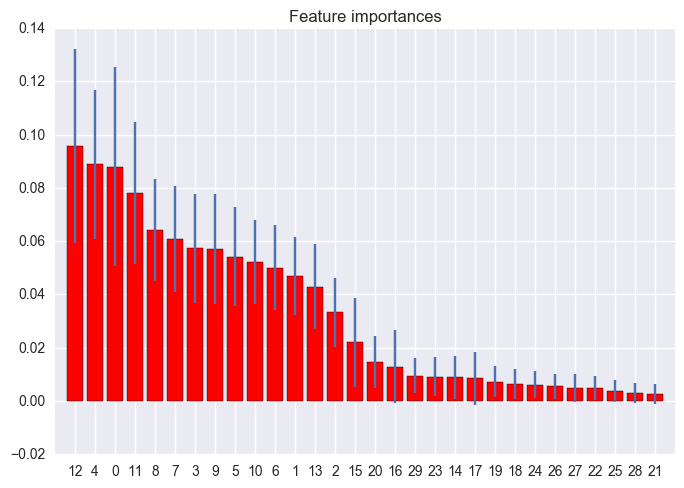

In [12]:
# Get the importance of the features
importances = rand_forest_model.feature_importances_

# Compute the standard deviation
std = np.std([tree.feature_importances_ for tree in rand_forest_model.estimators_], axis=0)

# Get the indices of the most important features, in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for feature in range(df_x.shape[1]):
    print("%d. feature %s (%f)" % (indices[feature], df_x.columns[feature], importances[indices[feature]]))
plt.figure()

plt.title("Feature importances")
plt.bar(range(df_x.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(df_x.shape[1]), indices)
plt.xlim([-1, df_x.shape[1]])
plt.show()

Let's now remove the features that we assume are the least useful to determine one's skin color.

We will delete the 10 most insignificant features.
By retraining the model and verifying its accuracy, we see it has improved slightly.

In [13]:
features_idx_to_remove = indices = np.argsort(importances)[1:9]
col_to_remove = df_x.columns[features_idx_to_remove]
df_x.drop(col_to_remove,inplace=True,axis=1,errors='ignore')


In [14]:
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(df_x, df_y, test_size=.2, random_state = 0)

rand_forest_model.fit(df_x_train,df_y_train)
# Predict from model neigh
y_pred = rand_forest_model.predict(df_x_test)

# Compute accuracy 
accuracy_rand_forest = sk.metrics.accuracy_score(df_y_test,y_pred)

# Print accuracy and exectution time
print(accuracy_rand_forest)

0.80985915493


The random forest will be trained again on the whole set, using the same model parameters.

In [15]:
rand_forest_model.fit(df_x,df_y)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

Let's have a look at the features importance now

Feature ranking:
1. feature seExp (0.099208)
2. feature height (0.090902)
3. feature redCards (0.089042)
4. feature games (0.082080)
5. feature meanIAT (0.064213)
6. feature victories (0.063527)
7. feature weight (0.063453)
8. feature goals (0.060760)
9. feature defeats (0.058194)
10. feature yellowCards (0.058020)
11. feature ties (0.052887)
12. feature meanExp (0.050100)
13. feature seIAT (0.046103)
14. feature age (0.034287)
15. feature England (0.021838)
16. feature France (0.014486)
17. feature Germany (0.013503)
18. feature Spain (0.008797)
19. feature Center Forward (0.008781)
20. feature Center Midfielder (0.008293)
21. feature Goalkeeper (0.008249)
22. feature Right Winger (0.003279)


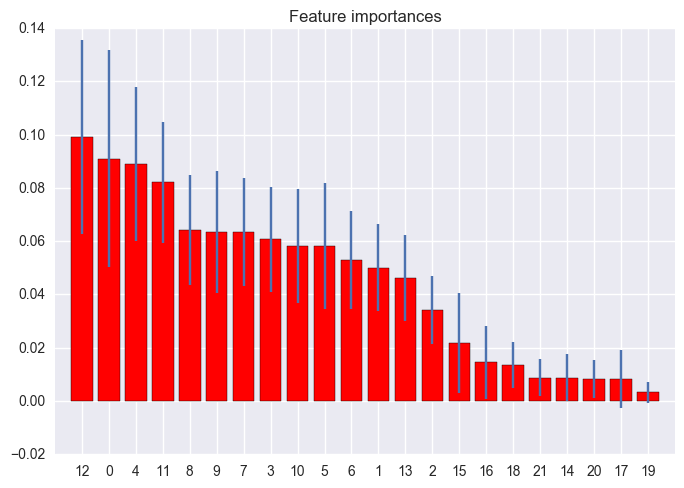

In [16]:
importances = rand_forest_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rand_forest_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(df_x.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, df_x.columns[f], importances[indices[f]]))
plt.figure()

plt.title("Feature importances")
plt.bar(range(df_x.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(df_x.shape[1]), indices)
plt.xlim([-1, df_x.shape[1]])
plt.show()

## Bonus question

Firstly the learning curve of the best model will be plotted. Using the features that could have an importance in determining a footballer's color skin

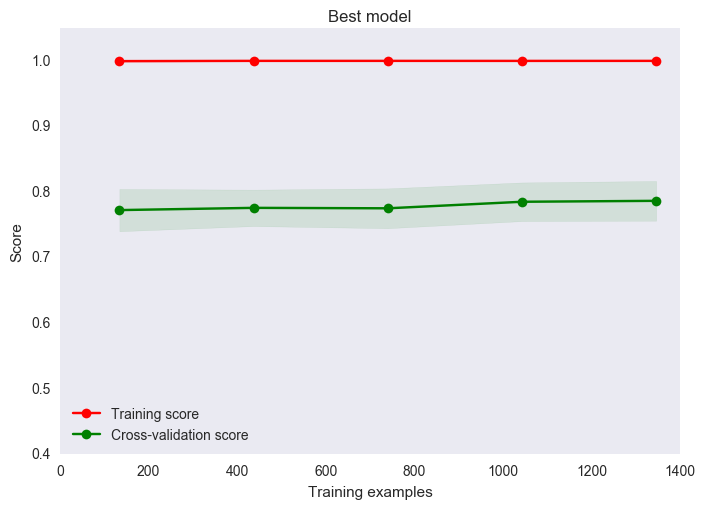

In [25]:
    rand_forest_model = sk.ensemble.RandomForestClassifier(n_estimators=best_param)
    plt.figure()
    plt.title("Best model")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(rand_forest_model, df_x, df_y, cv=20)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    axes = plt.gca()
    axes.set_ylim([0.4,1.05])

    plt.legend(loc="best")




Now the learning curve of the worst model will be plotted

In [26]:
rand_forest_model = sk.ensemble.RandomForestClassifier(n_estimators=worst_param)


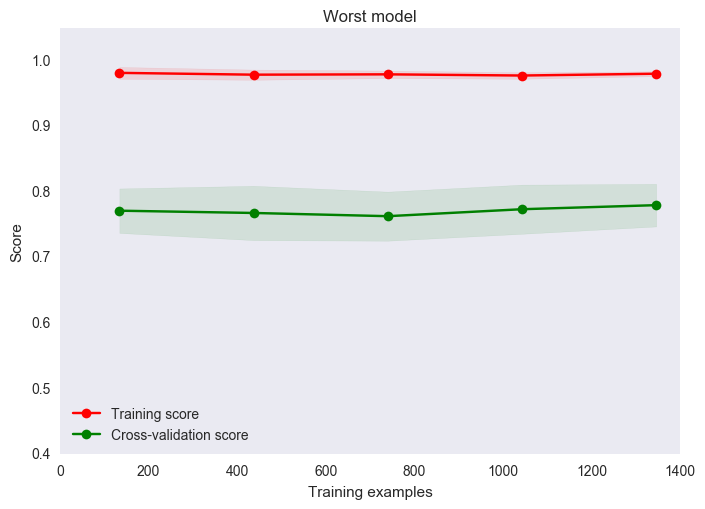

In [30]:
    plt.figure()
    plt.title("Worst model")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        rand_forest_model, df_x, df_y, cv=20)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    axes = plt.gca()
axes.set_ylim([0.4,1.05])

    plt.legend(loc="best")



As it can be seen the worst model was overfitting a lot, having an accuracy of 1 when training and showing a bad performance when testing on a subset of the data it hasn't trained on